In [7]:
import pandas as pd
import json

from pathlib import Path
import os
from tqdm import tqdm_notebook as tqdm

import gzip
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
import random
import collections
import pickle
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import datetime

import multiprocessing
from multiprocessing import Pool

In [20]:
def calc_mse(avg, hrs):
    dif = (np.array(hrs) - avg) ** 2
    return np.mean(dif)

def convert2datetime(unix_timestamp):
    utc_time = time.gmtime(unix_timestamp)
    l = time.localtime(unix_timestamp)
    dt = datetime.datetime(*l[:6])
    return dt

def parse(path):
    if 'gz' in path:
        f = gzip.open(path, 'rb')
    else:
        f = open(path, 'rb')
    for l in f.readlines():
        yield(eval(l.decode('ascii')))
        
def normalize(inp, zMultiple=5):
    mean, std = inp.mean(), inp.std()
    diff = inp - mean
    zScore = diff / std
    return zScore * zMultiple

In [8]:
# Load in the data
path = Path("part2data/")
in_path = str(path / "endomondoHR_proper.json")
def process(line):
    return eval(line)
pool = Pool(5)
with open(in_path, 'r') as f:
    data = pool.map(process, f)
pool.close()
pool.join()
print(len(data))

167783


In [9]:
data2 = data
print(len(data2))
user2workout = defaultdict(list)
idxMap={}
for idx in range(len(data2)):
    d = data2[idx]
    wid = d['id']
    uid = d['userId']
    user2workout[uid].append(wid)
    idxMap[wid] = idx
print(len(user2workout))

167783
1059


In [12]:
# sort a user's workout based on time
for u in user2workout:
    workout = user2workout[u]
    dts = [(convert2datetime(data2[idxMap[wid]]['timestamp'][0]), wid) for wid in workout]
    dts = sorted(dts, key=lambda x:x[0])
    new_workout = [x[1] for x in dts] # ascending
    user2workout[u] = new_workout

In [13]:
# keep 10 core
user2workout_core = defaultdict(list)
for u in user2workout:
    workout = user2workout[u]
    if len(workout) >= 10:
        user2workout_core[u] = workout
print(len(user2workout_core))

956


In [14]:
# Build timelines
times = defaultdict(float)
user_times = defaultdict(float)
for u in user2workout_core:
    workout = user2workout_core[u]
    tt = []
    for wid in workout:
        idx = idxMap[wid]
        d = data2[idx]
        ts = d['timestamp']
        times[wid] = (ts[-1] - ts[0]) / 3600
        tt.append((ts[-1] - ts[0])/3600)
    tt = np.array(tt).mean()
    user_times[u] = tt
    
vals = np.array(list(times.values()))
print(vals.mean())

1.4857973757216916


In [19]:
# contextMap stores all workouts previous to current
contextMap = {}
for u in user2workout_core:
    wids = user2workout_core[u]
    indices = [idxMap[wid] for wid in wids]
    
    # build start time
    start_times = []
    for idx in indices:
        start_time = data[idx]['timestamp'][0]
        start_times.append(start_time)
        
    # build context
    for i in range(1, len(wids)):
        wid = wids[i]
        since_last = (start_times[i] - start_times[i-1]) / (3600*24)
        since_begin = (start_times[i] - start_times[0]) / (3600*24)
        contextMap[wid] = (since_last, since_begin, wids[:i])

print(len(contextMap))

166417


In [21]:
# Normalize since_last and begin
since_last_array = []
since_begin_array = []
for wid in contextMap:
    t = contextMap[wid]
    since_last_array.append(t[0])
    since_begin_array.append(t[1])
    
since_last_array = np.array(since_last_array)
since_begin_array = np.array(since_begin_array)

since_last_array2 = normalize(since_last_array)
since_begin_array2 = normalize(since_begin_array)

In [22]:
# Put normalized since_last and begin into contextMap
i = 0
contextMap2 = {}
for wid in contextMap:
    t = contextMap[wid]
    t0 = since_last_array2[i]
    t1 = since_begin_array2[i]
    i += 1
    contextMap2[wid] = (t0, t1, t[2])
        

In [24]:
# split whole dataset, leave latest into valid and test
train, valid, test = [], [], []
for u in user2workout_core:
    indices = user2workout_core[u][1:]  # remove the first workout since it has no context...
    l = len(indices)
    # split in ascending order
    train.extend(indices[:int(0.8*l)])
    valid.extend(indices[int(0.8*l):int(0.9*l)])
    test.extend(indices[int(0.9*l):])
    
print("train/valid/test = {}/{}/{}".format(len(train), len(valid), len(test)))

train/valid/test = 132755/16604/17058


In [27]:
with open('endomondoHR_proper_temporal_dataset.pkl', 'wb') as f:
    pickle.dump((train,valid,test,contextMap2), f)

In [54]:
contextMap[train[0]]

(4.756423611111111, 4.756423611111111, [323000056])

In [28]:
df = pd.DataFrame(data)

In [29]:
df.head()

,longitude,altitude,latitude,sport,id,heart_rate,gender,timestamp,url,userId,speed
0,"[24.64977040886879, 24.65014273300767, 24.6509...","[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....","[60.173348765820265, 60.173239801079035, 60.17...",bike,396826535,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",male,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915,"[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3..."
1,"[24.649855233728886, 24.65015547350049, 24.650...","[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....","[60.173247596248984, 60.17320962622762, 60.172...",bike,392337038,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",male,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915,"[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30..."
2,"[24.64995657093823, 24.650197718292475, 24.651...","[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....","[60.17326201312244, 60.173205351457, 60.172969...",bike,389643739,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",male,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915,"[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3..."
3,"[24.649874344468117, 24.650242729112506, 24.65...","[28.6, 29.4, 29.4, 29.4, 28.0, 27.0, 25.2, 23....","[60.173286236822605, 60.17323946580291, 60.173...",bike,386729739,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...",male,"[1407432042, 1407432048, 1407432056, 140743206...",https://www.endomondo.com/users/10921915/worko...,10921915,"[7.4988, 15.4008, 17.8668, 21.5712, 24.1416, 3..."
4,"[24.64979832060635, 24.64992195367813, 24.6500...","[32.0, 32.0, 32.0, 35.8, 36.2, 36.2, 36.2, 36....","[60.17329327762127, 60.17327332869172, 60.1732...",bike (transport),383186560,"[110, 113, 114, 116, 123, 126, 129, 135, 137, ...",male,"[1406909434, 1406909436, 1406909437, 140690943...",https://www.endomondo.com/users/10921915/worko...,10921915,NaN


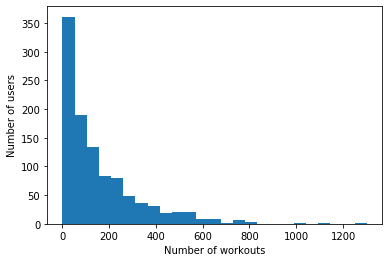

On average, each user has 158.43531633616618 workouts, with a median of 100.0


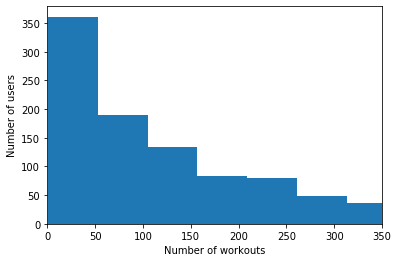

In [37]:
user_counts = df.groupby('userId').heart_rate.count()
plt.hist(user_counts.values, bins=25)
plt.xlabel("Number of workouts")
plt.ylabel("Number of users")
plt.show()
print(f"On average, each user has {user_counts.mean()} workouts, with a median of {user_counts.median()}")
plt.hist(user_counts.values, bins=25)
plt.xlim([0, 350])
plt.xlabel("Number of workouts")
plt.ylabel("Number of users")
plt.show()

In [38]:
user_counts.min()

1

In [40]:
import seaborn as sns

In [41]:
sport_counts = df.groupby('sport').userId.count()

In [43]:
sport_counts.index

Index(['aerobics', 'badminton', 'basketball', 'bike', 'bike (transport)',
       'circuit training', 'climbing', 'core stability training',
       'cross-country skiing', 'downhill skiing', 'elliptical',
       'fitness walking', 'golf', 'gymnastics', 'hiking', 'horseback riding',
       'indoor cycling', 'kayaking', 'kite surfing', 'martial arts',
       'mountain bike', 'orienteering', 'pilates', 'roller skiing', 'rowing',
       'rugby', 'run', 'sailing', 'skate', 'snowboarding', 'snowshoeing',
       'soccer', 'squash', 'stair climing', 'swimming', 'table tennis',
       'tennis', 'treadmill running', 'treadmill walking', 'walk',
       'weight training', 'windsurfing', 'yoga'],
      dtype='object', name='sport')

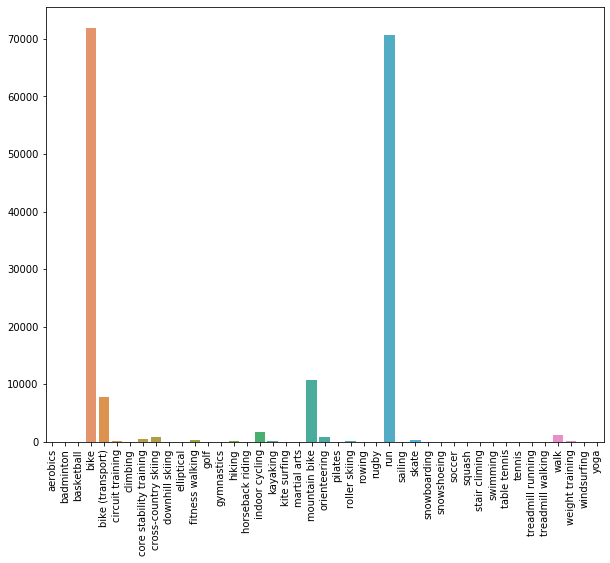

In [52]:
idxs = []
counts = []
for idx in sport_counts.index:
    idxs.append(idx)
    counts.append(sport_counts[idx])
plt.figure(figsize=(10,8))
sns.barplot(x=idxs, y=counts)
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_rotation(90)
plt.show()

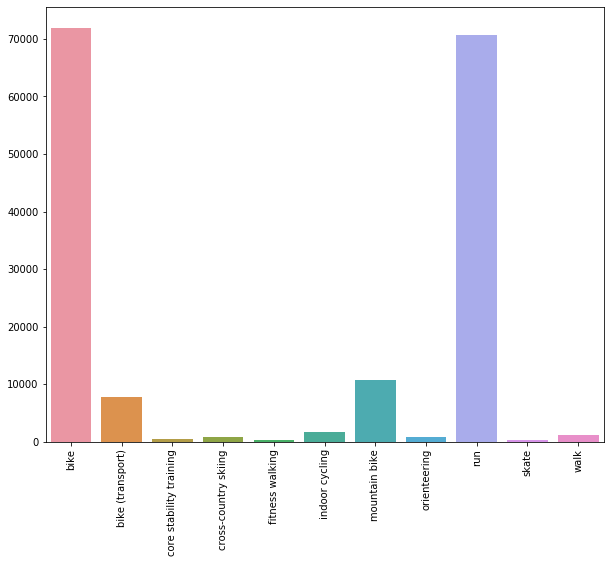

In [51]:
idxs = []
counts = []
for idx in sport_counts.index:
    if sport_counts[idx] > 250:
        idxs.append(idx)
        counts.append(sport_counts[idx])
plt.figure(figsize=(10,8))
sns.barplot(x=idxs, y=counts)
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_rotation(90)
plt.show()

In [59]:
genders = df.groupby('gender').userId.count()
genders

gender
female       9881
male       156717
unknown      1185
Name: userId, dtype: int64

In [61]:
genders['female'] / genders[['female','male']].sum()

0.05931043589959063

In [4]:
endo_data = pd.read_json('part2data/endomondoHR_proper.json', lines=True)a

ValueError: Expected object or value

In [ ]:
endo_data.head()

In [ ]:
endo_data.columns